In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import matplotlib.patches as patches
import jax.numpy as jnp 
import time
from jax import grad, hessian, jacfwd
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import fsolve
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['lines.linewidth'] = 2
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18) 
mpl.rc('font', size=18) 

# disable LaTeX rendering
plt.rcParams['text.usetex'] = False

x1 = λr (x[...,0])
x2 = V0 (x[...,1])
x3 = D (x[...,2])
x4 = cl_cd (x[...,3])

In [2]:
# define wind power function
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[0])*(x[0]+(1.32+((x[0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[0]**2/((x[3])*((x[0])+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[1])**2*(x[2])**2

g = 9.81 # gravitational acceleration (m*s^-2)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * x[1] / x[2]
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * x[3]) 

bounds = Bounds([5.0, 0.0, 120.0, 25.0], [10.0, 22.0, 145.0, 100.0])

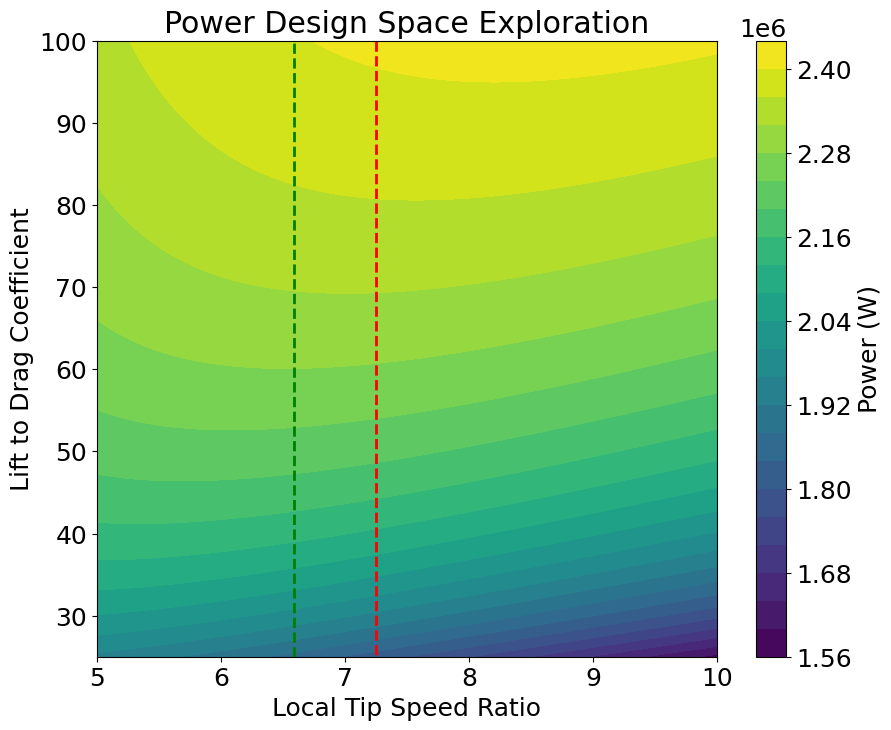

In [3]:
# let us fix x[1] (V0) and x[2] (D) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((x[...,3])*((x[...,0])+0.5/beta))
    return (np.pi/8)*CP*rho*(22)**2*(145)**2

# create meshgrid 
x0_range = np.linspace(5.0, 10.0, 100)
x3_range = np.linspace(25.0, 100.0, 100)
X0, X3 = np.meshgrid(x0_range, x3_range)
X1 = 22
X2 = 145

X = np.stack((X0, np.full_like(X0, 22), np.full_like(X0, 145), X3), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * 22 / 145
c3 = lambda x: 0.5 - 2 * 22**2 / (g * x[3])

# create a contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X0, X3, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Lift to Drag Coefficient')
plt.title('Power Design Space Exploration')

# plot constraints
plt.contour(X0, X3, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--')
plt.contour(X0, X3, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X0, X3, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--') # out of range anyways

# feasible region is right of red, left of green
plt.show()


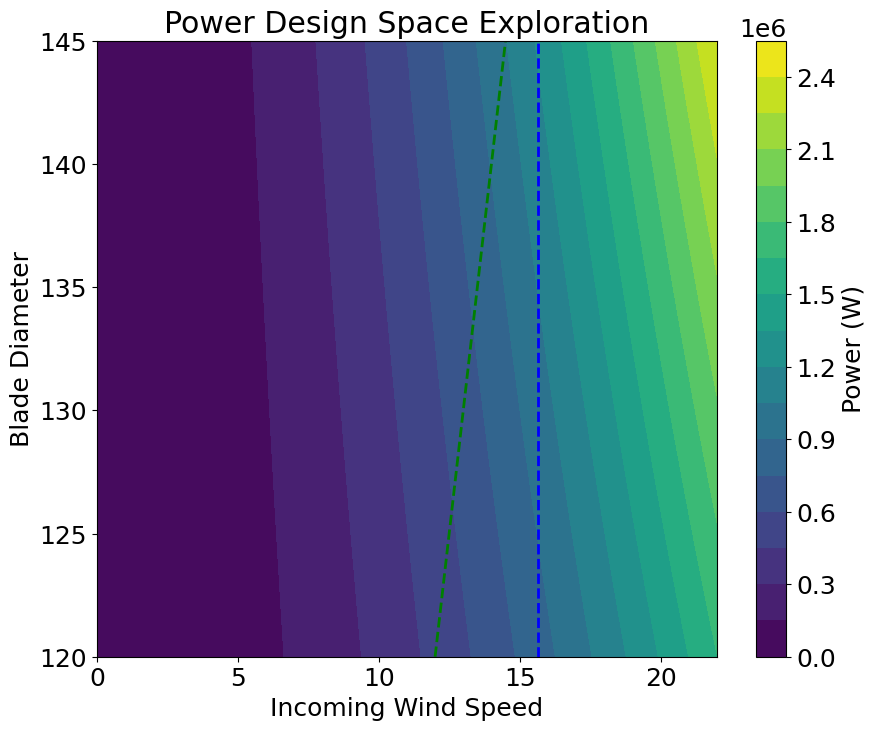

In [4]:
# let us fix x[0] (λr) and x[3] (cl/cd) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(10)*(10+(1.32+((10-8)/20)**2)/(beta**(2/3)))**-1-0.57*10**2/((100)*((10)+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[...,1])**2*(x[...,2])**2

# create meshgrid
x1_range = np.linspace(0.0, 22.0, 100)
x2_range = np.linspace(120.0, 145.0, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)

X = np.stack((np.full_like(X1, 10),X1, X2,np.full_like(X2, 100)), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * 10**5 -6*10**-6 * 10**4 + 0.0001 * 10**3 - 0.001 * 10**2 + 0.0048 * 10 + 0.3232) * (1-(1*10**-7 * 10**5 -6*10**-6 * 10**4 + 0.0001 * 10**3 - 0.001 * 10**2 + 0.0048 * 10 + 0.3232)))
c2 = lambda x: 2.0 - 2 * 10 * x[1] / x[2]
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * 100)

# create a contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X1, X2, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Incoming Wind Speed')
plt.ylabel('Blade Diameter')
plt.title('Power Design Space Exploration')


# plot constraints
#plt.contour(X1, X2, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--') # only dependent on X0
plt.contour(X1, X2, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X1, X2, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--') 

plt.show()


# feasible region is to lef

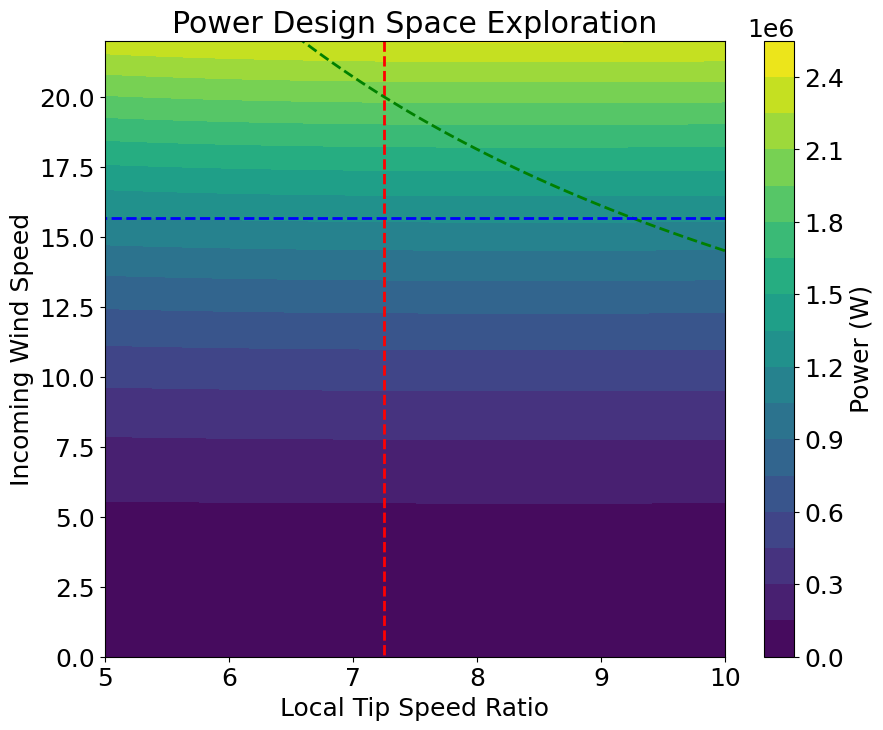

In [5]:
# let us fix x[2] (D) and x[3] (cl/cd) at their max. bounded values
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((100)*((x[...,0])+0.5/beta))
    return (jnp.pi/8)*CP*rho*(x[...,1])**2*(145)**2

# create meshgrid
x0_range = np.linspace(5.0, 10.0, 1000)
x1_range = np.linspace(0.0, 22.0, 1000)
X0, X1 = np.meshgrid(x0_range, x1_range)


X = np.stack((X0, X1, np.full_like(X0, 145), np.full_like(X1, 100)), axis=-1)

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * x[1] / 145
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * 100)


# create contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(X0, X1, power(X),20, cmap='viridis')
plt.colorbar(contour, label='Power (W)')
plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Incoming Wind Speed')
plt.title('Power Design Space Exploration')


# plot constraints
plt.contour(X0, X1, c1([X0, X1, X2, X3]), levels=[0], colors='r', linestyles='--')
plt.contour(X0, X1, c2([X0, X1, X2, X3]), levels=[0], colors='g', linestyles='--')
plt.contour(X0, X1, c3([X0, X1, X2, X3]), levels=[0], colors='b', linestyles='--')

# feasible region is below blue, below green, and to right of red
plt.show()


In [27]:
# define constraints for SciPy minimize
def power(x):
    rho = 1.225 # fluid density (kg*m^-3)
    beta = 2 # blade number (integer value)
    CP = (16/27)*(x[...,0])*(x[...,0]+(1.32+((x[...,0]-8)/20)**2)/(beta**(2/3)))**-1-0.57*x[...,0]**2/((x[...,3])*((x[...,0])+0.5/beta))
    return -1*(jnp.pi/8)*CP*rho*(x[...,1])**2*(x[...,2])**2

# define constraints
c1 = lambda x: 0.883 - (4 * ( 1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232) * (1-(1*10**-7 * x[0]**5 -6*10**-6 * x[0]**4 + 0.0001 * x[0]**3 - 0.001 * x[0]**2 + 0.0048 * x[0] + 0.3232)))
c2 = lambda x: 2.0 - 2 * x[0] * x[1] / x[2]
c3 = lambda x: 0.5 - 2 * x[1]**2 / (g * x[3]) 

ineq_con1 = {'type': 'ineq',
             'fun': c1,
             'jac': grad(c1)}
ineq_con2 = {'type': 'ineq',
             'fun': c2,
             'jac': grad(c2)}
ineq_con3 = {'type': 'ineq',
             'fun': c3,
             'jac': grad(c3)}

k = 0

# define a callback function to store optimization histories
def callback_tr(x, state):
    global k
    k += 1
    
    xx_tr.append(x) # iterate xk
    fx_tr.append(-1*state.fun) # function value
    c1x_tr.append(ineq_con1['fun'](x)) # constraint evaluation for c1 only
    c2x_tr.append(ineq_con2['fun'](x))
    c3x_tr.append(ineq_con3['fun'](x))
    
    constraint_vec_tr = [c1(x), c2(x), c3(x)]
    constraint_history_tr.append(constraint_vec_tr)
    
    print(f'xk_tr {x}, fk_tr {-1*state.fun}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')
    
# starting point
x0 = np.array([7.0, 18.0, 120.0, 25.0])

xx_tr = [] 
fx_tr = []
c1x_tr = [] 
c2x_tr = [] 
c3x_tr = [] 
constraint_history_tr = []

start_time_tr = time.time()

res = minimize(power, x0, method='trust-constr', jac=None,
               constraints=[ineq_con1, ineq_con2, ineq_con3],
               options=None,
               bounds=bounds, callback=callback_tr)

end_time_tr = time.time()
print("total execution time for trust-region constrained:", end_time_tr - start_time_tr, "seconds")


# determining MCV 

MCV_tr = []

for constraint_vec_tr in constraint_history_tr:
    new_constraint_vec_tr = [
        max(0, -constraint_vec_tr[0]),  
        max(0, -constraint_vec_tr[1]),    
        max(0, -constraint_vec_tr[2])  
    ]
    c_inf_tr = np.linalg.norm(new_constraint_vec_tr, ord=np.inf)
    
    MCV_tr.append(c_inf_tr)

xk_tr [  7.  18. 120.  25.], fk_tr 842707.7632166761, c1 -0.0005480279996398219, c2 -0.10000000000000009, c3 -2.1422018348623855
xk_tr [  6.74816934  18.45182138 120.14256692  25.17950765], fk_tr 898611.5503823626, c1 -0.001046558042386292, c2 -0.0728043104601972, c3 -2.2567173411881716
xk_tr [  5.44303872  20.4018328  120.53770686  26.07790103], fk_tr 1162152.956406003, c1 -0.0028062162177681094, c2 0.15745680325270506, c3 -2.75406874710633
xk_tr [  4.64343816  17.29125983 121.49001122  29.07071038], fk_tr 880094.8159378561, c1 -0.0032495156143259596, c2 0.6782304998296871, c3 -1.5968077717982911
xk_tr [  4.82158449  14.99159172 123.98545668  32.24545337], fk_tr 702991.4717669064, c1 -0.0031920765735286016, c2 0.8340047612964516, c3 -0.9209800908463519
xk_tr [  4.91132131  13.20981854 125.75036073  34.80207148], fk_tr 569359.109508621, c1 -0.003154082570943184, c2 0.9681514556931523, c3 -0.522232295322417
xk_tr [  5.0120538   11.97122084 126.97384737  36.8289152 ], fk_tr 481448.770252

xk_tr [  9.9999273   14.44345439 144.99959598  85.06027779], fk_tr 1015737.3653752686, c1 0.010877323255488736, c2 0.007808326648054198, c3 -7.294469739016485e-06
xk_tr [  9.99986536  14.48045071 144.99999798  85.4972819 ], fk_tr 1021662.2722147871, c1 0.010876951143046543, c2 0.0027233179824688314, c3 -3.2640979716891394e-06
xk_tr [  9.98732222  14.50942194 144.99999758  85.83995991], fk_tr 1026380.0143217181, c1 0.010801745053246936, c2 0.0012375935878321531, c3 -1.9553402845762236e-06
xk_tr [  9.95438138  14.55860834 144.99999758  86.42229297], fk_tr 1034472.7548863572, c1 0.010605623478223247, c2 0.0010766603087080107, c3 -5.669153227083612e-06
xk_tr [  9.92206746  14.60776521 144.99999758  87.00688837], fk_tr 1042579.176354552, c1 0.01041517084412702, c2 0.0008381471237455251, c3 -5.648723647166953e-06
xk_tr [  9.89046927  14.65685933 144.99999758  87.59270979], fk_tr 1050692.497204567, c1 0.010230776153432486, c2 0.0005073214245405744, c3 -5.596702236432272e-06
xk_tr [  9.8591767

xk_tr [  8.41043202  15.66045976 144.99999999  99.99999999], fk_tr 1222154.6253393216, c1 0.0033903923046830764, c2 0.18329334757807403, c3 1.10511100270827e-10
xk_tr [  8.41043202  15.66045976 144.99999999  99.99999999], fk_tr 1222154.6253393216, c1 0.0033903923046830764, c2 0.18329334757807403, c3 1.10511100270827e-10
xk_tr [  8.41043202  15.66045976 144.99999999  99.99999999], fk_tr 1222154.6253393216, c1 0.0033903923046830764, c2 0.18329334757807403, c3 1.10511100270827e-10
xk_tr [  8.41043202  15.66045976 144.99999999  99.99999999], fk_tr 1222154.6253393216, c1 0.0033903923046830764, c2 0.18329334757807403, c3 1.10511100270827e-10
xk_tr [  8.41043202  15.66045976 144.99999999  99.99999999], fk_tr 1222154.6253393216, c1 0.0033903923046830764, c2 0.18329334757807403, c3 1.10511100270827e-10
xk_tr [  8.41043202  15.66045976 144.99999999  99.99999999], fk_tr 1222154.6253393216, c1 0.0033903923046830764, c2 0.18329334757807403, c3 1.10511100270827e-10
xk_tr [  8.41043202  15.66045976 1

In [45]:
# COBYLA


ineq_con1 = {'type': 'ineq',
             'fun': c1,
             'jac': grad(c1)}
ineq_con2 = {'type': 'ineq',
             'fun': c2,
             'jac': grad(c2)}
ineq_con3 = {'type': 'ineq',
             'fun': c3,
             'jac': grad(c3)}

k_c = 0  
# define a callback function to store optimization histories
def callback_c(x):
    global k_c
    k_c += 1
    
    xx_c.append(x) # iterate xk
    fk_c_value = power(x)
    fx_c.append(-1*fk_c_value) # function value
    c1x_c.append(ineq_con1['fun'](x)) # constraint evaluation for c1 only
    c2x_c.append(ineq_con2['fun'](x))
    c3x_c.append(ineq_con3['fun'](x))
    
    constraint_vec_c = [c1(x), c2(x), c3(x)]
    constraint_history_c.append(constraint_vec_c)
    
    print(f'xk_c {x}, fk_c {-1*fk_c_value}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')

# starting point
x0 = np.array([6.0, 18.0, 120.0, 25.0])

xx_c = [] 
fx_c = []
c1x_c = [] 
c2x_c = [] 
c3x_c = [] 
constraint_history_c = []

constraints=[ineq_con1, ineq_con2, ineq_con3]


start_time_c = time.time()

res = minimize(power, x0, method='COBYLA', jac=None,
               constraints=constraints,
               options=None,
               bounds=bounds, callback=callback_c)  

end_time_c = time.time()
print("total execution time for COBYLA:", end_time_c - start_time_c, "seconds")

# determining MCV 

MCV_c = []

for constraint_vec_c in constraint_history_c:
    new_constraint_vec_c = [
        max(0, -constraint_vec_c[0]),  
        max(0, -constraint_vec_c[1]),  
        max(0, -constraint_vec_c[2])
    ]
    
    c_inf_c = np.linalg.norm(new_constraint_vec_c, ord=np.inf)
    
    MCV_c.append(c_inf_c)    

xk_c [  7.  18. 120.  25.], fk_c 842707.7632166761, c1 -0.0005480279996398219, c2 -0.10000000000000009, c3 -2.1422018348623855
xk_c [  6.  19. 120.  25.], fk_c 971915.4215093378, c1 -0.002216728309759941, c2 0.10000000000000009, c3 -2.443934760448522
xk_c [  6.  19. 121.  25.], fk_c 988181.5059943205, c1 -0.002216728309759941, c2 0.11570247933884303, c3 -2.443934760448522
xk_c [  6.  19. 121.  26.], fk_c 1001024.2521747649, c1 -0.002216728309759941, c2 0.11570247933884303, c3 -2.3307065004312713
xk_c [  6.          18.06375084 121.          26.35133674], fk_c 908670.6604522169, c1 -0.002216728309759941, c2 0.2085536358613398, c3 -2.024493203412401
xk_c [  6.          17.13605352 120.9440623   26.7204555 ], fk_c 820534.8281217875, c1 -0.002216728309759941, c2 0.29977066827474563, c3 -1.7404680278058575
xk_c [  6.          16.27907478 120.7570358   27.20067267], fk_c 742260.8447177708, c1 -0.002216728309759941, c2 0.3822980077931788, c3 -1.4862814212858078
xk_c [  6.          15.32955844

In [50]:
# SLSQP

k_slsqp = 0  
# define a callback function to store optimization histories
def callback_slsqp(x):
    global k_slsqp
    k_slsqp += 1
    
    xx_slsqp.append(x) # iterate xk
    fk_slsqp_value = power(x)
    fx_slsqp.append(-1*fk_slsqp_value) # function value
    c1x_slsqp.append(ineq_con1['fun'](x)) 
    c2x_slsqp.append(ineq_con2['fun'](x))
    c3x_slsqp.append(ineq_con3['fun'](x))
    
    constraint_vec_slsqp = [c1(x), c2(x), c3(x)]
    constraint_history_slsqp.append(constraint_vec_slsqp)
    
    print(f'k_s {k_slsqp}, xk_slsqp {x}, fk_slsqp {-1*fk_slsqp_value}, c1 {c1(x)}, c2 {c2(x)}, c3 {c3(x)}')


x0 = np.array([5.0, 5.0, 120.0, 25.0])

xx_slsqp = [] 
fx_slsqp = []
c1x_slsqp = [] 
c2x_slsqp = [] 
c3x_slsqp = [] 
constraint_history_slsqp = []
constraints=[ineq_con1, ineq_con2, ineq_con3]

start_time_slsqp = time.time()

res = minimize(power, x0, method='SLSQP', jac=None,
               constraints=constraints,
               options=None,
               bounds=bounds, callback=callback_slsqp)

end_time_slsqp = time.time()
print("total execution time for SLSQP:", end_time_slsqp - start_time_slsqp, "seconds")

# determining MCV

MCV_slsqp = []

for constraint_vec_slsqp in constraint_history_slsqp:
    new_constraint_vec_slsqp = [
        max(0, -constraint_vec_slsqp[0]),  
        max(0, -constraint_vec_slsqp[1]),  
        max(0, -constraint_vec_slsqp[2])
    ]
    
    c_inf_slsqp = np.linalg.norm(new_constraint_vec_slsqp, ord=np.inf)
    
    MCV_slsqp.append(c_inf_slsqp)

k_s 1, xk_slsqp [  6.49320817  16.13448793 145.         100.        ], fk_slsqp 1288624.6818387723, c1 -0.0014961477128010436, c2 0.5549711887563691, c3 -0.030727218947331658
k_s 2, xk_slsqp [ 10.  22. 145. 100.], fk_slsqp 2404418.2452234374, c1 0.010877759999999959, c2 -1.0344827586206895, c3 -0.48674821610601426
k_s 3, xk_slsqp [ 10.  22. 145. 100.], fk_slsqp 2404418.2452234374, c1 0.010877759999999959, c2 -1.0344827586206895, c3 -0.48674821610601426
k_s 4, xk_slsqp [  9.20270173  16.14985788 145.         100.        ], fk_slsqp 1298651.2717204164, c1 0.006640732887883138, c2 -0.04996310355944944, c3 -0.031738857123422615
k_s 5, xk_slsqp [  8.27011726  16.11717369 145.         100.        ], fk_slsqp 1294441.4532012672, c1 0.0029007336702375763, c2 0.1615046027380329, c3 -0.02958876200490501
k_s 6, xk_slsqp [  9.22459868  16.46306601 145.         100.        ], fk_slsqp 1349450.949284045, c1 0.006743264185390507, c2 -0.09469209592058414, c3 -0.05256379684723955
k_s 7, xk_slsqp [  9.2

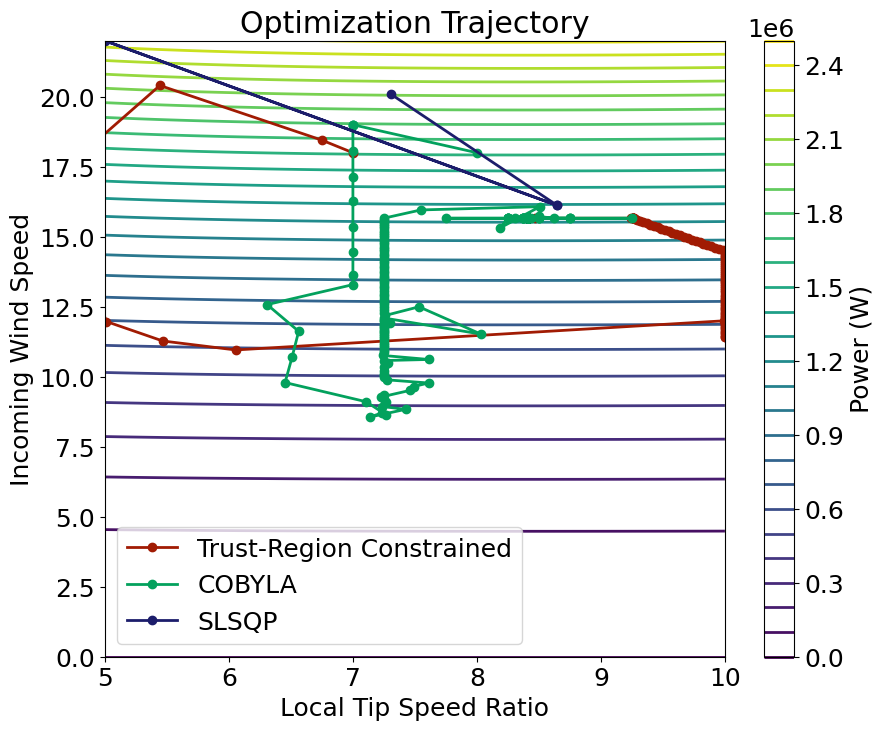

In [30]:
# Optimization Trajectory

plt.figure(figsize=(10, 8))
contour = plt.contour(X0, X1, -1*power(X), 25, cmap='viridis')
plt.colorbar(contour, label='Power (W)')

# plot trust-region algorithm
x1_tr = [x[0] for x in xx_tr]
x2_tr = [x[1] for x in xx_tr]

# plot COBYLA algorithm
x1_c = [x[0] for x in xx_c]
x2_c = [x[1] for x in xx_c]

# plot SLSQP algorithm
x1_slsqp = [x[0] for x in xx_slsqp]
x2_slsqp = [x[1] for x in xx_slsqp]

plt.plot(x1_tr, x2_tr, marker='o', c='#a11b03', label='Trust-Region Constrained')
plt.plot(x1_c, x2_c, marker='o', c='#03a15d', label='COBYLA')
plt.plot(x1_slsqp, x2_slsqp, marker='o', c='#1c1d6b', label='SLSQP')


plt.xlabel('Local Tip Speed Ratio')
plt.ylabel('Incoming Wind Speed')
plt.title('Optimization Trajectory')
plt.xlim(5.0, 10.0)  
plt.ylim(0, 22.0)
plt.legend()
plt.show()



<Figure size 1000x800 with 0 Axes>

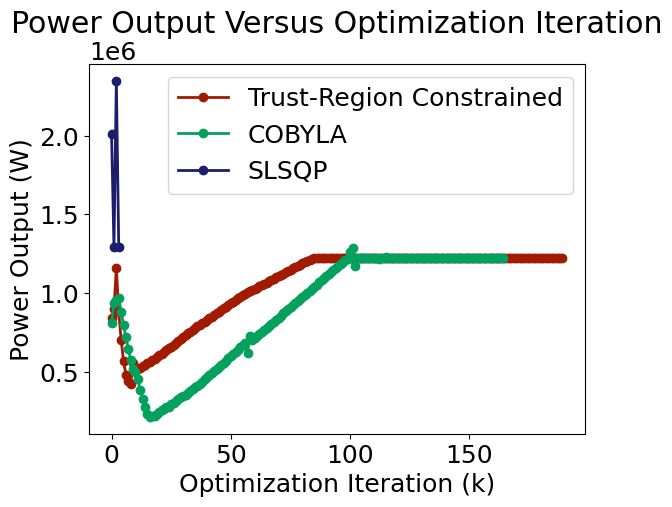

In [31]:
# Function Value vs. Optimization Iteration

plt.figure(figsize=(10, 8))
plt.figure()
plt.plot(range(len(fx_tr)), fx_tr, marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(fx_c)), fx_c, marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(fx_slsqp)), fx_slsqp, marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Power Output (W)')
plt.title('Power Output Versus Optimization Iteration')
plt.legend()
plt.show()



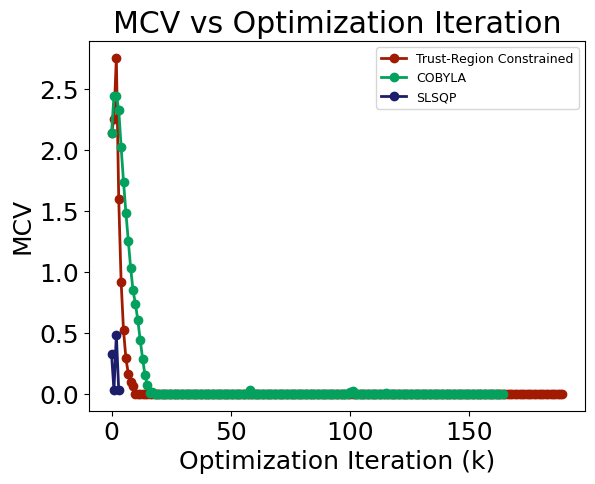

In [32]:
# Maximum Constraint Violation

plt.plot(range(len(c1x_tr)), MCV_tr, marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(c1x_c)), MCV_c, marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(c1x_slsqp)), MCV_slsqp, marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('MCV')
plt.title('MCV vs Optimization Iteration')
plt.legend(fontsize='9')
plt.show()

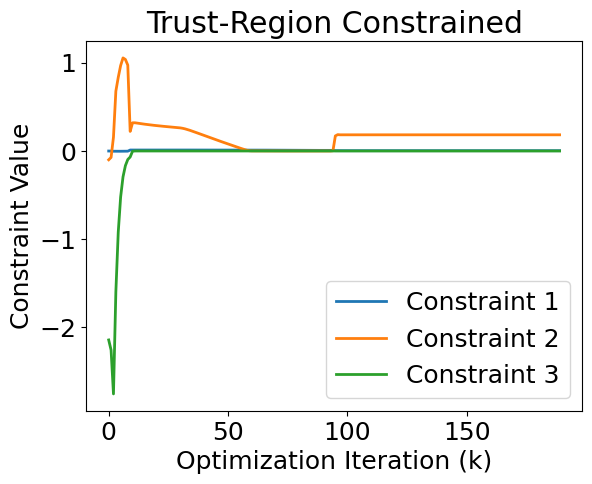

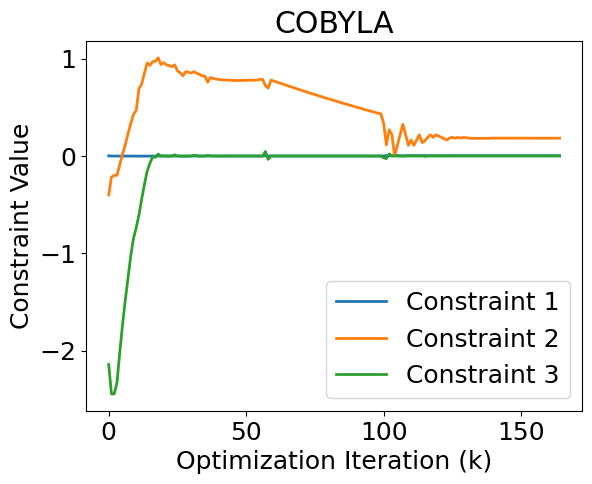

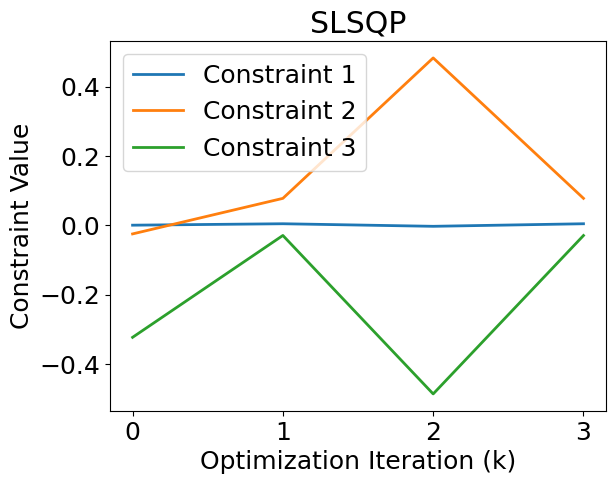

In [34]:
# Trust-Region Constrained
plt.figure()
plt.plot(range(len(c1x_tr)), c1x_tr, label='Constraint 1')
plt.plot(range(len(c2x_tr)), c2x_tr, label='Constraint 2')
plt.plot(range(len(c3x_tr)), c3x_tr, label='Constraint 3')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Constraint Value')
plt.title('Trust-Region Constrained')
plt.legend()
plt.show()

# COBYLA
plt.figure()
plt.plot(range(len(c1x_c)), c1x_c, label='Constraint 1')
plt.plot(range(len(c2x_c)), c2x_c, label='Constraint 2')
plt.plot(range(len(c3x_c)), c3x_c, label='Constraint 3')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Constraint Value')
plt.title('COBYLA')
plt.legend()
plt.show()

# SLSQP
plt.figure()
plt.plot(range(len(c1x_slsqp)), c1x_slsqp, label='Constraint 1')
plt.plot(range(len(c2x_slsqp)), c2x_slsqp, label='Constraint 2')
plt.plot(range(len(c3x_slsqp)), c3x_slsqp, label='Constraint 3')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Constraint Value')
plt.title('SLSQP')
plt.legend()
plt.show()

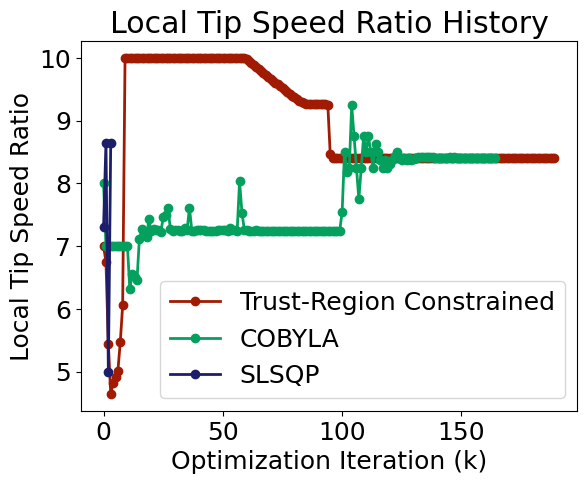

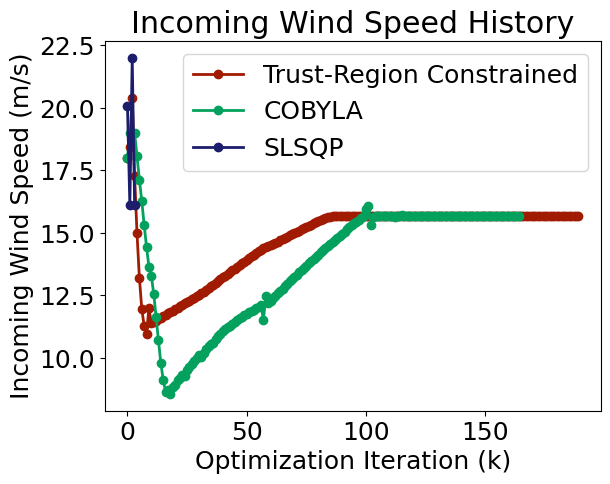

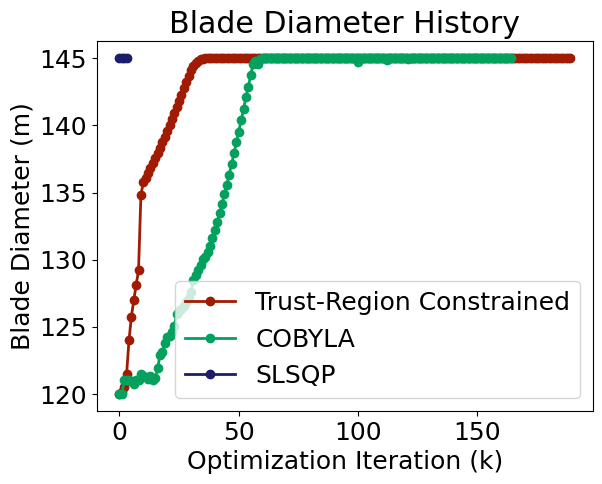

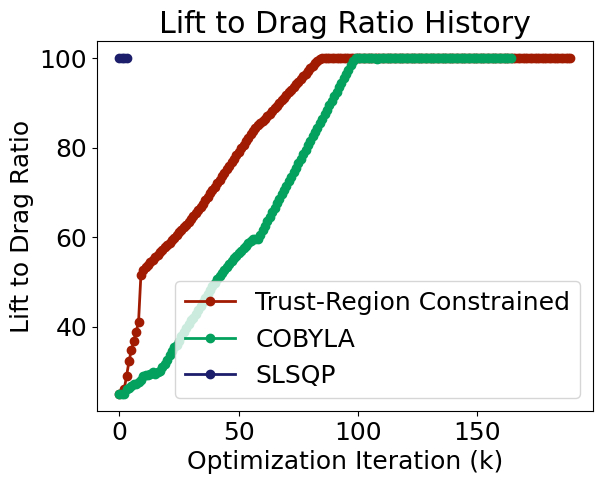

In [44]:
# Local Tip Speed Ratio History
plt.figure()
plt.plot(range(len(xx_tr)), [x[0] for x in xx_tr], marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(xx_c)), [x[0] for x in xx_c], marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(xx_slsqp)), [x[0] for x in xx_slsqp], marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Local Tip Speed Ratio')
plt.title('Local Tip Speed Ratio History')
plt.legend()
plt.show()

# Incoming Wind Speed History
plt.figure()
plt.plot(range(len(xx_tr)), [x[1] for x in xx_tr], marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(xx_c)), [x[1] for x in xx_c], marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(xx_slsqp)), [x[1] for x in xx_slsqp], marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Incoming Wind Speed (m/s)')
plt.title('Incoming Wind Speed History')
plt.legend()
plt.show()

# Blade Diameter History
plt.figure()
plt.plot(range(len(xx_tr)), [x[2] for x in xx_tr], marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(xx_c)), [x[2] for x in xx_c], marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(xx_slsqp)), [x[2] for x in xx_slsqp], marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Blade Diameter (m)')
plt.title('Blade Diameter History')
plt.legend()
plt.show()

# Lift to Drag Ratio History
plt.figure()
plt.plot(range(len(xx_tr)), [x[3] for x in xx_tr], marker='o',c='#a11b03', label='Trust-Region Constrained')
plt.plot(range(len(xx_c)), [x[3] for x in xx_c], marker='o',c='#03a15d', label='COBYLA')
plt.plot(range(len(xx_slsqp)), [x[3] for x in xx_slsqp], marker='o',c='#1c1d6b', label='SLSQP')
plt.xlabel('Optimization Iteration (k)')
plt.ylabel('Lift to Drag Ratio')
plt.title('Lift to Drag Ratio History')
plt.legend()
plt.show()